# Frequency of stable conditions at various sites
    - Snoqualmie
    - Shallow Cold Pool

In [42]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [9]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'
dirDataSCP = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'

## Define Functions

### Bulk Richardson

# Open data

In [14]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2)**(1. / 2.))
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2)**(1. / 2.))

### Stability

In [15]:
# -------------------------------------------------------------------------------------------------------
# SNQ
RiBulk, _, _ = turbpy.bulkRichardson(SNQ.T6 + 273.15,
                                     SNQ.Tsrf + 273.15,
                                     SNQ.WIND,
                                     6. - SNQ.Snowdepth,
                                     False)
SNQ['RiBulk'] = RiBulk

# -------------------------------------------------------------------------------------------------------
# SCP
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

### Temperature gradients

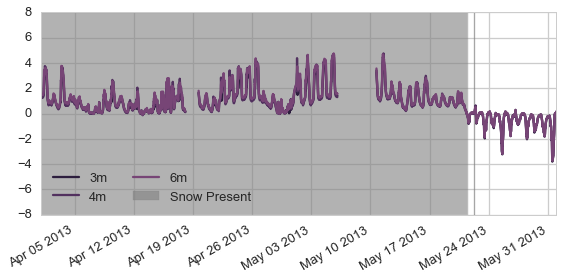

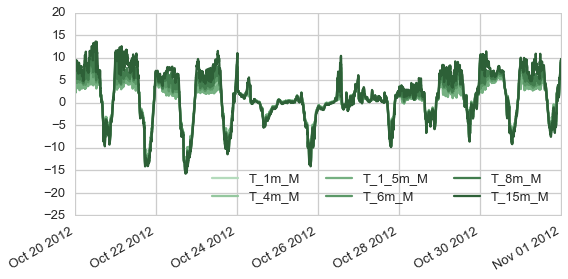

In [16]:
# -------------------------------------------------------------------------------------------------------
# Plot tempearture gradients by height
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# SNQ
pal1 = sns.cubehelix_palette(8,reverse=True)
ax.plot(SNQ.time, (SNQ.T3 - SNQ.Tsrf) / (6 - SNQ.Snowdepth), label='3m', color=pal1[0])
ax.plot(SNQ.time, (SNQ.T4 - SNQ.Tsrf) / (6 - SNQ.Snowdepth), label='4m', color=pal1[1])
ax.plot(SNQ.time, (SNQ.T6 - SNQ.Tsrf) / (6 - SNQ.Snowdepth), label='6m', color=pal1[2])
ax.fill_between(SNQ.time.values, -8, 8, where=SNQ.SP, color='grey', alpha=.6, label='Snow Present')

ax.set_xlim(datetime(2013,4,1), datetime(2013,6,1))
ax.legend(loc='best', ncol=2)
fig.autofmt_xdate()
fig.tight_layout()

# SCP
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
pal2 = sns.cubehelix_palette(6, start=2, rot=0, dark=.3, light=.8)
tempVars = ['T_1m_M', 'T_4m_M', 'T_1_5m_M', 'T_6m_M', 'T_8m_M', 'T_15m_M']
tempHeights = np.array((1, 4, 5, 6, 8, 15))
for n,v in enumerate(tempVars):
#     ax.plot(SCP.time, (SCP[v] - SCP.Tsfc) / tempHeights[n], label=v, color=pal2[n])
    ax.plot(SCP.time, (SCP[v] - SCP.Tsfc), label=v, color=pal2[n])
ax.set_xlim(datetime(2012, 10, 20), datetime(2012, 11, 1))
ax.legend(loc='best', ncol=3)

fig.autofmt_xdate()
fig.tight_layout()

# Frequency of Stability


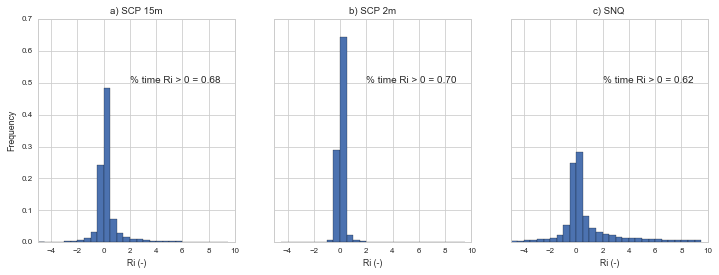

In [43]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax = axes[0]
x = SCP.RiBulk_15m[~np.isnan(SCP.RiBulk_15m)]
weights = np.ones_like(x) / float(len(x))
ax.hist(x, bins=np.arange(-5, 10, .5), weights=weights, edgecolor=None)
ax.set_xlim(-5, 10)
ax.set_ylabel('Frequency')
ax.set_xlabel('Ri (-)')
ax.set_title('a) SCP 15m')
ax.text(2, .5, '% time Ri > 0 = ' + '%0.2f' % ((x > 0).mean(dim='time')))

ax = axes[1]
x = SCP.RiBulk_2m[~np.isnan(SCP.RiBulk_2m)]
weights = np.ones_like(x) / float(len(x))
ax.hist(x, bins=np.arange(-5, 10, .5), weights=weights, edgecolor=None)
ax.set_xlim(-5, 10)
ax.set_xlabel('Ri (-)')
ax.set_title('b) SCP 2m')
ax.text(2, .5, '% time Ri > 0 = ' + '%0.2f' % ((x > 0).mean(dim='time')))

ax = axes[2]
x = SNQ.RiBulk[(SNQ.RiBulk > -5) & (SNQ.RiBulk < 10)]
weights = np.ones_like(x) / float(len(x))
ax.hist(x, bins=np.arange(-5, 10, .5), weights=weights, edgecolor=None)
ax.set_xlim(-5, 10)
ax.set_xlabel('Ri (-)')
ax.set_title('c) SNQ')
ax.text(2, .5, '% time Ri > 0 = ' + '%0.2f' % ((x > 0).mean(dim='time')))

fig.savefig('TF.StableFraction.Histogram.pdf', bbox_inches='tight')

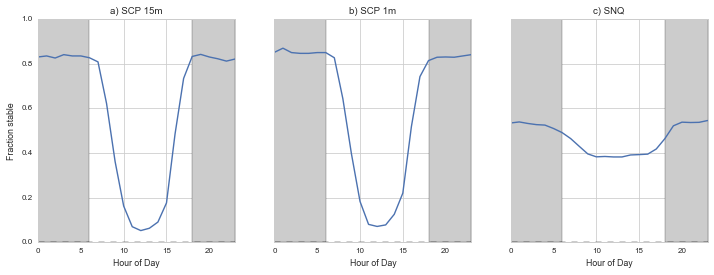

In [44]:
# Format figure
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
os.chdir(dirPrint)
hours = np.arange(0, 24)

# -------------------------------------------------------------------------------------------------------
# SCP - 15m
ax = axes[0]
ymin = 0
ymax = 1
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
ax.plot(hours, 
        (SCP['RiBulk_15m'] > 0).groupby('time.hour').mean(dim='time').roll(hour=-6))

# Format
# ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Fraction stable')
ax.set_xlabel('Hour of Day')
ax.set_title('a) SCP 15m')

# -------------------------------------------------------------------------------------------------------
# SCP - 1m
ax = axes[1]
ymin = 0
ymax = 1
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
ax.plot(hours, 
        (SCP['RiBulk_2m'] > 0).groupby('time.hour').mean(dim='time').roll(hour=-6))

# Format
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Hour of Day')
ax.set_title('b) SCP 1m')

# -------------------------------------------------------------------------------------------------------
# SNQ
ax = axes[2]
ymin = 0
ymax = 1
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')

ax.plot(hours, 
        (SNQ['RiBulk'] > 0).groupby('time.hour').mean(dim='time'))

# Format
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Hour of Day')
ax.set_title('c) SNQ')

# -------------------------------------------------------------------------------------------------------
# Final formatting
fig.savefig('TF.StableFraction.DiurnalComposites.pdf', bbox_inches='tight')